<a href="https://colab.research.google.com/github/pachterlab/bibecs183/blob/master/Colab_Notebooks/aux4_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auxiliary tutorial 4: Principal Component Analysis

(c) 2016 Heidi Klumpe and Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](aux4_pca.ipynb).*

In [71]:
!pip install bebi103

In [0]:
import numpy as np
import numba
import pandas as pd
import scipy.special
import scipy.stats as st

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# BE/Bi 103 Utilities from Justin
import bebi103

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh
bokeh.io.output_notebook()

#### Overview

1. Principal component analysis (PCA) summarizes a multi-dimensional dataset with fewer dimensions, while still preserving important underlying structure. Stated differently, it removes smaller, high-order correlations in the hopes of revealing the larger (and presumably more important) first-order variations.
2. We can implement PCA in two ways: using the eigenvectors of the covariance matrix or with packages from `scikit-learn`.
3. We need to be careful about choosing to use PCA as a visual heuristic or statistical tool, whether we're analyzing our own data or reading about someone else's.

## Using PCA in the biological sciences

Biological datasets, thanks to technological advances and the suffix "-omics," are high-dimensional. We can record information about every gene, protein, or brain voxel, but then would like to isolate the most descriptive (or maybe predictive) features of those measurements. Ideally, we could remove apparent redundancies or unimportant features, and so be able to focus on the underlying structure that remains. For this reason, we often want to reduce the dimensionality of the data, i.e. summarize it with a smaller number of features. 

PCA, invented by Karl Pearson [in 1901](http://stat.smmu.edu.cn/history/pearson1901.pdf), provides a way to do just that! Given a dataset with $p$ dimensions (where each dimension could be the measurement of a single gene, or cytokine, or SNP), we can project all observations into a set of $k$ new dimensions, which end up being linear combinations of the original dimensions. Though some information is "lost" in this reduction, PCA preserves the maximal variation in those new dimensions. So projecting data onto its principal components removes the potentially superficial distinctions of the extra dimensions whilst highlighting important differences. To get a more intuitive idea of how this works, try clicking around in these [interactive plots](http://setosa.io/ev/principal-component-analysis/).

PCA has been used in many interesting ways. One 2-D rendering of SNPs [regenerated the geography of Europe](http://www.nature.com/nature/journal/v456/n7218/fig_tab/nature07331_F1.html). Other examples include [classifying different soft tissue tumors](http://www.sciencedirect.com/science/article/pii/S0140673602082703); [visualizing gene oscillations](http://www.pnas.org/content/103/44/16254.full) and subsequently intuiting [genetic networks](http://www.pnas.org/content/97/15/8409.full); and [removing noise from genetic data](http://www.pnas.org/content/97/18/10101.full).

## Using PCA in Python

We will perform PCA two ways. First, with techniques from linear algebra, to get an idea of what we are doing. Second, with packages from `scikit-learn`, which allow us to do PCA in a single line!

### With techniques from linear algebra

This [blog post](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html) by Sebastian Raschka provides a clean and useful overview of our approach to PCA. This is what we will implement in the following lines to reduce our data to $k$ dimensions:

1. Standardize the data. (To make quantitative comparisons of variance, we want to be sure each measurement varies to a similar extent; more on this later.)
2. Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.
3. Select the $k$ largest eigenvalues and their associated eigenvectors.
4. Transform the data into a $k$ dimensional subspace using those $k$ eigenvectors.

Let's give it a try!

#### The famous iris data set

We will use one of the most famous datasets available online. This data set, collected by Edgar Anderson and popularized by the one and only [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), contains the petal and sepal length and width in three different species of Iris (*Iris setosa*, *Iris virginica* and *Iris versicolor*). 

This data set is popular enough to have its own [Wikipedia entry](https://en.wikipedia.org/wiki/Iris_flower_data_set), and you can import it with [seaborn](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=iris), [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), or even pandas using

    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')

For this tutorial, we will import it using `scikit-learn` and transform it into a tidy data frame.

In [73]:
# Import the Iris dataset and convert it into a Pandas DataFrame
iris = sklearn.datasets.load_iris()

# Uncomment if you want to print the dataset description
# print(iris.DESCR)

# Make a DataFrame with a species column
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can plot pairwise comparisons using Seaborn's `pairplot()` function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

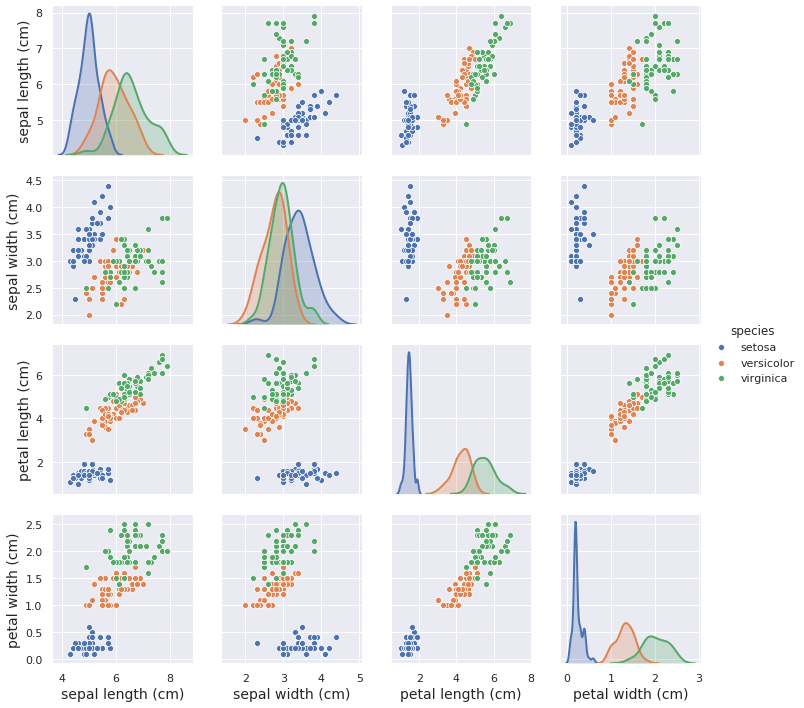

In [74]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  There is also a strong correlation between *petal length* and *petal width*. We can use this to explain the concept behind PCA. So, let's focus on these two parameters.

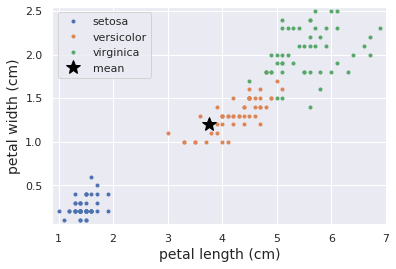

In [75]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

Now, we do "manual" PCA (or "Manuel" PCA, as he coded this approach first). Our goal will be to reduce our 2-D data to 1-D. Note that by taking the mean, we already reduced it 0-D in a sense.

**1) Standardize the data.**
Because our plot labels have units, we know the two dimensions we're considering are both measured in centimeters, and so have similar scale. But they're different distances from zero! We'll center all measurements at the same point, the mean.

In [76]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()

# Take a look
df_centered.head()

,petal length (cm),petal width (cm)
0,-2.358,-0.999333
1,-2.358,-0.999333
2,-2.458,-0.999333
3,-2.258,-0.999333
4,-2.358,-0.999333


**2) Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.** 

We won't cover the math behind this procedure. However, [it can be shown](https://en.wikipedia.org/wiki/Principal_component_analysis#First_component) that the principal component directions are given by the eigenvectors of the matrix, and the magnitudes of the components are given by the eigenvalues. 

Most of the available algorithms to do PCA use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) instead for computational efficiency. But regardless of the algorithm the objective is still the same: compute the eigenvectors and eigenvalues from the covariance matrix.

In [77]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

Covariance matrix 
 [[3.11627785 1.2956094 ]
 [1.2956094  0.58100626]]


Next, we'll compute the eigensystem.

In [78]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[ 0.92177769 -0.38771882]
 [ 0.38771882  0.92177769]]

Eigenvalues
 [3.66123805 0.03604607]


We can plot the eigenvectors on top of our data to get a sense of how these principal components can capture the variation in the data.

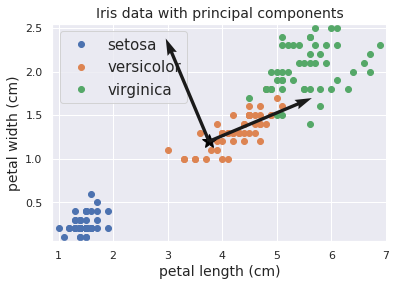

In [79]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

**3) Select the $k$ largest eigenvalues and their associated eigenvectors.**

As [Sebastian Raschka](http://sebastianraschka.com/index.html) points out in his explanation of PCA:

>*The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes*.

We chose this pair of measurements originally because there was a clear correlation between them. This is indeed confirmed by the relative magnitudes of the *eigenvalues* where one of them is two orders of magnitude larger than the other. Clearly, describing this data with two axes, rather than one, does not add much additional information. Also, we know which eigenvector to take: the one with the largest eigenvalue.

[Lior Pachter's great blog post on PCA](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/), which we will discuss more later, explains this 2-D to 1-D case by thinking of the projection as a triangle. Let's say we want to project a single data point onto the first principal component. The centroid (fixed) and the data point (also fixed) form a triangle with the the transformed data point (an orthogonal projection onto the first principal component). 

The hypotenuse of the triangle (the distance from the centroid to the data point) is fixed, so the other two sides must change together (by the Pythagorean Theorem). The first principal component has a minimal orthogonal distance to all the data points. So the side of the triangle between the data point and the transformed data point is as small as possible. This means the distance between the centroid and the transformed point is as large as possible (though still smaller than the original distance between the data point and the centroid)! 

This is what we mean when we say that using PCA to project the data into fewer dimensions maximizes the sample variation (i.e. their distances from each other after they've been transformed), despite some information being lost.

Luckily, we can quantify about how much information is lost. As the eigenvalues are a relative measure of the data variance along the associated eigenvector (i.e. the "new feature axis"), we can use them to quantify how much of the variance is explained by our $k$ dimensions, which could be a useful way to decide what $k$ should even be in the first place. In this case, we want to know how much of the 2-D spread is described by our 1-D simplification.

In [80]:
# Compute how much variance is explained by each principal component
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / np.sum(eig_vals) * 100)))


PCA 1: 99.03% of the variance
PCA 2:  0.97% of the variance



**4) Transform the data into a $k$ dimensional subspace using those $k$ eigenvectors.**

To actually project our data into this new dimension, we have to multiply our data by the so-called projection matrix, which is the fancy name for concatenating the top $k$ eigenvectors together. Then, the dot product of the data with the projection matrix "projects" the data onto our new axis.

Since in this simple example we are projecting into a 1D space, we just have to matrix multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [81]:
# Project data to our 1D space
df_1D = pd.DataFrame(np.dot(df_iris.loc[:,['petal length (cm)',
                                           'petal width (cm)']], eig_vecs[:,0]),
                     columns=['projection'])

# Add back the species column
df_1D['species'] = df_iris['species']
df_1D.head()

,projection,species
0,1.368033,setosa
1,1.368033,setosa
2,1.275855,setosa
3,1.460210,setosa
4,1.368033,setosa


Now we can plot our data in 1D only while maintaining ≈98% percent of the variability in the data!

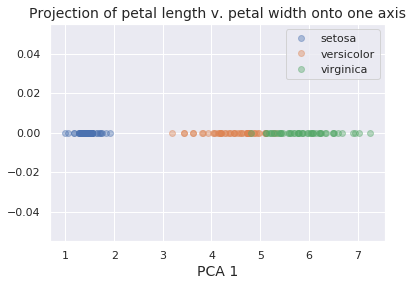

In [82]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.zeros_like(group['projection']), alpha=0.4, 
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.legend(np.array(['setosa', 'versicolor','virginica']))
plt.title('Projection of petal length v. petal width onto one axis');

Exciting! We were able to project 2-D data onto a 1-D axis, and still have a sense of how these various iris species differ. Note that while the new dimension has numerical values, its interpretation is a bit fuzzy. It's in fact a weighted combination of *petal length* and *petal width*, but this doesn't necessarily tell us anything new about biology, except that these two variables are related and potentially very different in various iris species. However, we might have known this by computing their covariance.

### `Scikit-learn` shortcut

Now that we explored step-by-step how to do PCA, we can use `scikit-learn` to do it in a single line.  For this, we will take all 4 dimensions of the original dataset (petal length, petal width, sepal length, and sepal width) and explore how much variability is explained by each of the resulting principal components.

`Scikit-learn` utilizes Python's object orientation. An object is first instantiated by the user, and has various variables (i.e. class and instance variables) and methods (i.e. functions) you can access (more definitions [here](https://www.tutorialspoint.com/python/python_classes_objects.htm)). We first instantiate a `sklearn.decomposition.PCA` object, and the use the `fit()` method to get PCA on our data.  The attributes of the `PCA` instance that end in underscores are the computed values.

In [83]:
# Instantiate the PCA object
sklearn_pca = sklearn.decomposition.PCA()

# Pass the data to the fit method
sklearn_pca.fit(df_iris[iris.feature_names])

# Print the variance explained
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.92461872 0.05306648 0.01710261 0.00521218]


We can see that the first component captures 92% of the variability in the data! We can now easily project our 4-D dataset into any $k$ dimensional space we would like. Since we've already seen a 0-D and 1-D reduction, let's look at the data in 2-D space.

In [84]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['species'] = df_iris['species']

# Look at the result
df_2D.head()

,PCA1,PCA2,species
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa


Now we can plot our original 4-D data onto a 2-D space that retains nearly 93% of the variability.

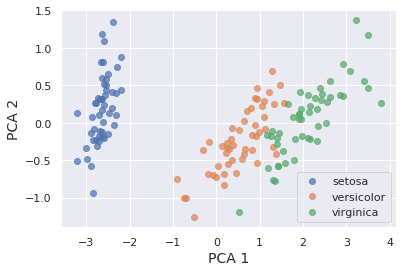

In [85]:
for key, group in df_2D.groupby(['species']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2');

Interesting! This single plot summarizes what we intuited from looking at *all* the dimensions with our pairwise plot. The species are relatively distinct, with *versicolor* and *viriginica* being more similar to each other than to *setosa*. Also, the second axis doesn't add much additional information; for the most part, it seems to capture the variation within species, rather than something that makes these flowers phenotypically distinct.

## Summary

So what have we learned by doing this analysis?

#### We can implement PCA in Python.

Methodologically, there are two ways to do it: approaches from linear algebra, or with `scikit-learn`.

Practically, PCA takes a $p$ dimensional dataset as input and outputs two things that might interest us: 
* a transformed dataset in $k$ dimensions and 
* a set of eigenvectors and associated eigenvectors that indicate the "percent variance" explained. 

Here, the transformed dataset was our endpoint, since we were satisfied to think about high-dimensional differences as a 1 or 2-D distances. But can we learn something about data from the way we transformed it? Is it more than a visual heuristic? Is a plot my only reward for all this adventurous math?

#### PCA doesn't necessarily provide statistical information or a useful metric. But it will make your data easier to look at.

Even if, as in the case of the iris data, we had a single principal component that described most of the variation, it is not necessarily wise to use that as a mathematical or statistical model for the data. In fact, we may know beforehand that we do not expect to predict the data with purely linear relationships. What's more, as the weights of the principal components do not necessarily represent physical quantities, such models can be hard to verify with pre-existing data. See an internet rant about ["Unprincipled Component Analysis"](http://www.win-vector.com/blog/2014/02/unprincipled-component-analysis/) for more information.

Also note that PCA is not scale invariant; you can easily imagine that if we analyzed the same measurements, but in different units, the eigenvector weights would be very different! Moreover, a dimension varying from 0.1 to 0.2 might be considered much less significant than a dimension varying from 100 to 200. So any implementation of PCA includes a somewhat subjective choice of scale, though [scale-invariant methods](http://uhra.herts.ac.uk/bitstream/handle/2299/715/S56.pdf) do exist.

To capture the confusion around the true usefulness of PCA in data analysis, Lior Pachter collected these quotations in his [blog post on PCA](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/) (all emphasis ours):
* "PCA **is not a statistical method** to infer parameters or test hypotheses. Instead, it provides a method to reduce a complex dataset to lower dimension to reveal sometimes hidden, simplified structure that often underlie it."
* "PCA **is a statistical method** routinely used to analyze interrelationships among large numbers of objects."
* PCA is "more useful as **a visualization technique** than as an analytical method."
* PCA is a "mathematical algorithm that reduces the dimensionality of the data while **retaining most of the variation** in the data set."

However, as we might intuit, the eigenvalues and eigenvectors do contain some statistical information. Pachter talks about other approaches to using PCA, which are more interested in the new dimensions onto which the data is projected, rather than the projected data itself. For example, the new dimensions define an "affine subspace closest to a set of points." In 0-D, this is the centroid, or the single point closest to all the data points. In 1-D, when we collapse the data onto a single line, that line is the "average line" at a minimal _orthogonal_ distance from all the data.

If that last part sounds a bit like least squares regression, it's because they are related! Pachter's second definition describes how probabilitistic PCA is "a generalization of linear regression in which Gaussian noise is isotropic." We showed in class that a least squares regression is equivalent to maximizing the likelihood, if we assume Gaussian distributed errors in the dependent variable. (Note that this minimizes the _vertical_ distince between the data and the line.) However, for biological processes, we often expect noise in the independent **and** dependent variables. Our "affine subspace," or the dimension onto which we project our data, may describe data better than a linear regression, as it considers both sources of noise (more information [here](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/)).

#### PCA invokes certain assumptions, and so works well on specific datasets: similarly-scaled, high signal-to-noise ratio, with primarily linear relationships.

As described above, to make good quantitative comparison of variation, we must have data where "large" and "small" variation occur on the same scale. Also, by stating that the largest-order variation is the most scientifically interesting, we assume that the signal to noise ratio is fairly high, such that the lower-order variation we remove will be noise, or at least less crucial to summarizing the data usefully.

Other clustering approaches, which we will discuss in future auxiliary tutorials, may provide "better" ways to summarize high dimensional data. However, as we've learned throughout this course, the appropriateness of a technique depends on the question that you're asking. PCA will summarize the data without you specifying a structure beforehand, but doesn't necessarily categorize the data; other approaches, like k-means clustering, will return discrete clusters but require you to know something about the structure of the data beforehand, e.g. the number of clusters.

## Using PCA to find the perfect human.

Genomes are hard to interpret. And so are PCA plots. Lior Pachter makes both these points in an interesting [blog post](https://liorpachter.wordpress.com/2014/12/02/the-perfect-human-is-puerto-rican/), where he calculates who the perfect human being would be according to their genomic SNP profile.

[SNPedia](http://www.snpedia.com/) is a database that contains a compilation of SNPs classified as *good* or *bad* according to some [GWAS](https://en.wikipedia.org/wiki/Genome-wide_association_study) criteria.
Lior did the following:

1. He created a "perfect human" *in silico* by setting the alleles at all SNPs so that they are "good".
2. He then added the "perfect human" to a panel of genotyped individuals from across a variety of populations and performed **PCA** to reveal the location and population of origin of the individual that was closest to this hypothetical perfect human.

We will use his data and repeat the analysis to find out who the perfect human being is and where is he/she from.  You can download the SNP table, as well as information about the subjects [here](../data/pachter.zip).

We will load it into a `DataFrame` where each column heading refers to a SNP and each row is a given subject.  The index of the row is a string representing the subject (including `'perfect'`), and the column headings are the SNP IDs.

In [86]:
!wget http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2016/data/pachter.zip

--2020-01-23 17:51:26--  http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2016/data/pachter.zip
Resolving bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com (bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com)... 52.217.40.243
Connecting to bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com (bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com)|52.217.40.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 758184 (740K) [application/zip]
Saving to: ‘pachter.zip.2’

pachter.zip.2       100%[===================>] 740.41K  --.-KB/s    in 0.06s   

2020-01-23 17:51:26 (11.2 MB/s) - ‘pachter.zip.2’ saved [758184/758184]



In [87]:
!unzip pachter.zip
!mv pachter/* .

Archive:  pachter.zip
  inflating: pachter/geno_table.txt  
  inflating: pachter/integrated_call_samples_v3.20130502.ALL.panel  


In [88]:
# Read the SNP table
df_snp = pd.read_csv('geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()
df_snp.head()

snp_id,rs307377,rs7366653,rs41307846,rs3753242,rs35082957,rs34154371,rs35426403,rs1143016,rs3890745,rs17472401,rs34248917,rs10489535,rs202191898,rs74315352,rs7520292,rs4908760,rs6688832,rs17368528,rs28730670,rs150726175,rs121908162,rs121908163,rs2003046,rs80356718,rs72550870,rs17036350,rs4846033,rs2274976,rs17375901,rs4846051,rs1801131,rs1801133,rs3737965,rs198358,rs5067,rs5065,rs5064,rs5063,rs121913554,rs138382758,...,rs76060075,rs1081004,rs78854695,rs1081003,rs28371706,rs76802407,rs29001678,rs1065852,rs28371696,rs769258,rs1080993,rs1080992,rs59099247,rs78047908,rs1080987,rs1080986,rs76210340,rs75471486,rs1080984,rs58188898,rs121965009,rs28940571,rs738409,rs6006460,rs16992796,rs6007413,rs121918186,rs1800206,rs4253778,rs11090865,rs6007897,rs9615362,rs9627183,rs28372448,rs121913039,rs121913037,rs5770917,rs6151429,rs743616,rs2071421
perfect,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,1,0,0,0,0,0,0,2,0,0,0,2,0,0,2,2,0,0,2,2,2,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HG00096,2,0,1,0,0,0,0,0,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
HG00097,2,0,0,0,0,0,0,0,1,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
HG00099,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,2,0,1,2,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
HG00100,2,0,0,0,0,0,0,0,1,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


Because we will do PCA with these data, they should be floating point numbers instead of integers.

In [0]:
df_snp = df_snp.astype(np.float)

We also have data about each individual, such as where they are from.  The `integrated_call_samples_v3.20130502.ALL.panel` file is also included in the [ZIP file](../data/pachter.zip) containing the data.

In [90]:
# Read the description of each individual
fname = 'integrated_call_samples_v3.20130502.ALL.panel'
df_info = pd.read_csv(fname, delimiter='\t', 
                      index_col=0).dropna(axis=1, how='all')
df_info.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


For convenience, we'll add this information to the SNP `DataFrame`.

In [91]:
# Add to the SNP dataframe the information about gender and super_pop
aux_cols = ['pop', 'super_pop', 'gender']
df_snp[aux_cols] = df_info

# Change the super_pop column for the perfect human being
df_snp.loc['perfect', ['pop', 'super_pop']] = ['Perfect Human']*2

# Take a look at auxiliary columns
df_snp[aux_cols].head()

snp_id,pop,super_pop,gender
perfect,Perfect Human,Perfect Human,NaN
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female


**A note about units:** Remember, as we discussed above, the subspaces that you obtain from performing PCA are not scale invariant. This means that, for example, if your dataset contains things measured in *nanometers* and things measured in *meters*, or even worse things measuring completely unrelated things, the units in which your measurement is stored would affect the PCA analysis.

The simplest way to avoid this issue is to form a "**common set of units**" by standardizing your values such that they all have a common mean and variance (usually set to be zero and one respectively). Though still a somewhat subjective choice, this ensures that variance in each dimension happen on roughly the same scale.

Fortunately, as in almost every case, `scikit-learn` can do the job for us. We will simply use the `StandardScaler` class from the `preprocessing` module of `scikit-learn` to fix this.

In [92]:
# Standardize the data before performing PCA
# We use .drop to remove the gender and super_pop columns to avoid errors.
df_snp_std = sklearn.preprocessing.StandardScaler().fit_transform(
                            df_snp.drop(aux_cols, axis=1))

# Perform the PCA and transform the data
n_components = 5
snp_pca = sklearn.decomposition.PCA(n_components=n_components)

# Project the data into this 2D space
snp_pca.fit(df_snp_std)
df_snp_pca = snp_pca.transform(df_snp_std)

# Convert back to a nice tidy dataframe
df_snp_pca = pd.DataFrame(df_snp_pca, 
                columns=['PC' + str(x) for x in range(1, n_components+1)], 
                index=df_snp.index)

# Add again the gender, pop, and super_pop columns
df_snp_pca[aux_cols] = df_snp[aux_cols]
df_snp_pca.head()

,PC1,PC2,PC3,PC4,PC5,pop,super_pop,gender
perfect,-2.221873,-13.823952,193.949874,26.727827,-2.302516,Perfect Human,Perfect Human,NaN
HG00096,-6.037516,-15.947683,0.535822,-3.397242,-3.557039,GBR,EUR,male
HG00097,-6.310191,-14.804931,1.029009,-13.751841,4.556677,GBR,EUR,female
HG00099,-7.102287,-15.820245,4.379395,-4.119878,-3.085048,GBR,EUR,female
HG00100,-6.006800,-17.297061,0.388331,-4.471314,-2.657358,GBR,EUR,female


Great! Now, we know that plotting our multi-dimensional data in 2-D will give us an idea of which points are similar and dissimilar. So, if we believe genetic fitness is entirely determined by the absence and presence of universally good and bad SNPs, we may be interested in which humans are closest to the "perfect" human created by Lior Pachter. (Shortly after, we may offer our services to Hydra.) We will find this out by plotting all the SNP profiles in 2-D space.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


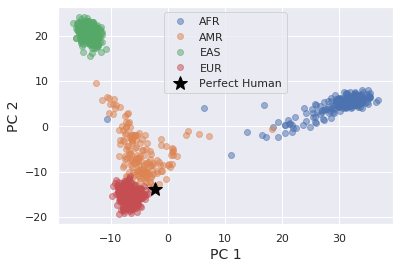

In [93]:
# Plot all populations except the perfect human
cols = ~df_snp_pca['super_pop'].isin(['Perfect Human'])
df_gb = df_snp_pca[cols].groupby(['super_pop'])
for key, group in df_gb:
    plt.plot(group.PC1, group.PC2, 'o', alpha=0.5, label=key)

# Add the perfect human being to the plot
plt.plot(df_snp_pca.ix['perfect'].PC1, df_snp_pca.ix['perfect'].PC2, '*', 
         markersize=15, color='black', label=df_snp_pca.ix['perfect'].super_pop)

# Tidy the plot.
plt.margins(0.05)
plt.legend(loc=0)
plt.xlabel('PC 1')
plt.ylabel('PC 2');

The closest point to the perfect human being is patient [HG00737](https://catalog.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=HG00737&PgId=166) a ***Puerto Rican woman***!\**

How confident are we that this plot indicates a Puerto Rican woman is the closest to being perfect? What if we considered additional axes?

Wow! The perfect human is actually... not human. What happened here?

We didn't check how much variance the first two axes explained; for the most part, we picked two dimensions because we publish papers in a two-dimensional format. It seems that there is a *significant* amount of variance explained by the third axis. In fact, it separates the "perfect" human from all other humans.

In [94]:
print('Variance percent explained\n', snp_pca.explained_variance_ratio_)

Variance percent explained
 [0.05660433 0.04227824 0.00728842 0.00597726 0.0054038 ]


It seems our plot explains less than 10% of the variation. A 2-D plot is vastly oversimplified. Looking at the 3-D plot, we see how we fooled ourselves.

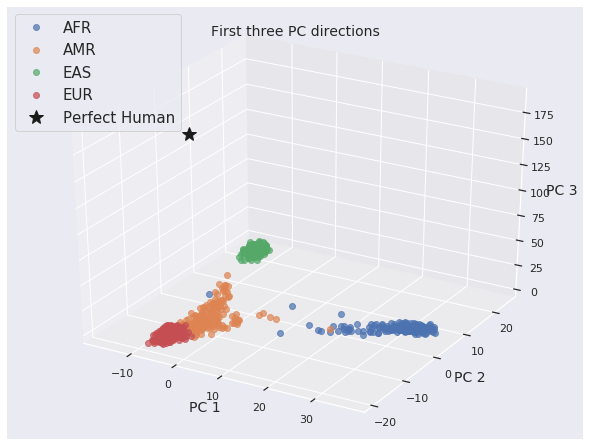

In [95]:
fig = plt.figure(1, figsize=(8, 6))
ax = mpl_toolkits.mplot3d.Axes3D(fig)
for key, group in df_snp_pca.groupby(['super_pop']):
    if key == 'Perfect Human':
        ax.plot(group.PC1, group.PC2, group.PC3, 'k*', markersize=15,
                label=key)
    else:
        ax.plot(group.PC1, group.PC2, group.PC3, 'o', alpha=0.7, label=key)

ax.set_title("First three PC directions")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend(loc='upper left', fontsize=15);

This is an important reminder that PCA removes some variance to help us focus on the largest (and presumably most important) variance. Here however, there was important information even in the "lower" order variation. By plotting in 2-D, we implicitly assumed that most of the structure of SNP variation is itself 2-D. Perhaps, for something very complex like genomes, we should expect many higher order interactions to be still be important to understanding the system.

**A note on Pachter's analysis:** This blog post ended up being fairly controversial because it is so easy to (mis)interpret the 2-D PCA plot. Lior's original intent was to show that James Watson's racist ideas of having a perfect human being were completely wrong. Instead, however, most people took the sarcastic title seriously. Eventually, scientists from Puerto Rico, who collected the samples, [explained the actual results](http://www.oleksyk.com/why-there-cant-be-a-perfect-human-from-puerto-rico-or-anywhere-else/) for the people that only read Lior's title.

#### Footnotes*
\*Coincidentally, iris is the state cultivated flower of Tennessee, where I (Heidi) grew up, though the state [wildflower](https://en.wikipedia.org/wiki/Passiflora_incarnata) is much more exciting.  

\*\*But we are sure that Lin-Manuel Miranda, a Puerto Rican man, is a close second. That man is [non-stop](https://www.youtube.com/watch?v=8aefuWGmKTY).  

*(dedicated to Christina Su, the human version of GitHub, who restored the accidentally discarded first draft)*